# Evaluating the Silhuette Score

The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) provides a more detailed picture of cluster quality. It answers the question: how far are the points in the nearest cluster relative to the points in the assigned cluster?
To this end, it compares the mean intra-cluster distance (a) to the mean distance of the nearest-cluster (b) and computes the following score s:

$$s=\frac{b−a}{\max(a,b)}\quad\in{[−1, 1]}$$

The score can vary between -1 and 1, but negative values are unlikely in practice because they imply that the majority of points are assigned to the wrong cluster. A useful visualization of the silhouette score compares the values for each data point to the global average because it highlights the coherence of each cluster relative to the global configuration. The rule of thumb is to avoid clusters with mean scores below the average for all samples.

In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score
from IPython import display
from time import sleep

In [2]:
sns.set_style('white')
cmap = ListedColormap(sns.color_palette('Paired', 10))

In [3]:
data = pd.read_csv('data/heart_disease_cleaned.csv')

In [4]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(data)

pca_x = pca_data[:, 0]
pca_y = pca_data[:, 1]

In [5]:
kmeans_kwargs = {
"init": "k-means++",
"n_init": 15,
"random_state": 42,
}

In [6]:
n_clusters = 2
max_clusters = 7
kmeans = KMeans(n_clusters, **kmeans_kwargs)

kmeans.fit(pca_data)

c:\Users\Christian\anaconda3\envs\ml-env\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


KMeans(n_clusters=2, n_init=15, random_state=42)

#### Der er lige kommet lidt inertia med her

Men der er mere af det i Inertia_Evaluation.ipynb

In [7]:
def inertia_plot_update(inertias, ax, delay=1):
    inertias.plot(color='k',
                  lw=1,
                  title='Inertia',
                  ax=ax,
                  xlim=(inertias.index[0], inertias.index[-1]),
                  ylim=(0, inertias.max()))
    ax.set_xlabel(f"Clusters")
    ax.set_ylabel("Inertia Value")
    ax.axes.get_xaxis().set_visible(True)
    ax.axes.get_yaxis().set_visible(True)    
    display.display(plt.gcf())
    display.clear_output(wait=True)
    sleep(delay)

### Silhouette plot metoder

In [8]:
def plot_silhouette(values, y_lower, i, n_cluster, ax):
    cluster_size = values.shape[0]
    y_upper = y_lower + cluster_size

    color = plt.cm.viridis(i / n_cluster)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, values,
                facecolor=color, edgecolor=color, alpha=0.7)
    ax.text(-0.05, y_lower + 0.5 * cluster_size, str(i))
    y_lower = y_upper + 10
    return y_lower

In [9]:
def format_silhouette_plot(ax):
    ax.set_title("Silhouette Plot")
    ax.set_xlabel(f"Silhouette Coefficient: {silhouette_avg}")
    ax.set_ylabel("Cluster Label")
    ax.axvline(x=silhouette_avg, 
               color='red', 
               linestyle='--', 
               lw=1)
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

In [10]:
def plot_final_assignments(x, y, centroids, 
                           assignments, n_cluster, ax):
    c = plt.cm.viridis(assignments / n_cluster)
    ax.scatter(x, y, marker='.', s=30, 
               lw=0, alpha=0.7, c=c, edgecolor='k')
    ax.scatter(*centroids.T, marker='o',  
               c='w', s=200, edgecolor='k')
    for i, c in enumerate(centroids):
        ax.scatter(*c, marker='${}$'.format(i), 
                   s=50, edgecolor='k')

    ax.set_title('{} Clusters'.format(n_cluster))

In [11]:
cluster_list = list(range(1, max_clusters + 1))
inertias = pd.Series(index=cluster_list)

0.43270114922851904


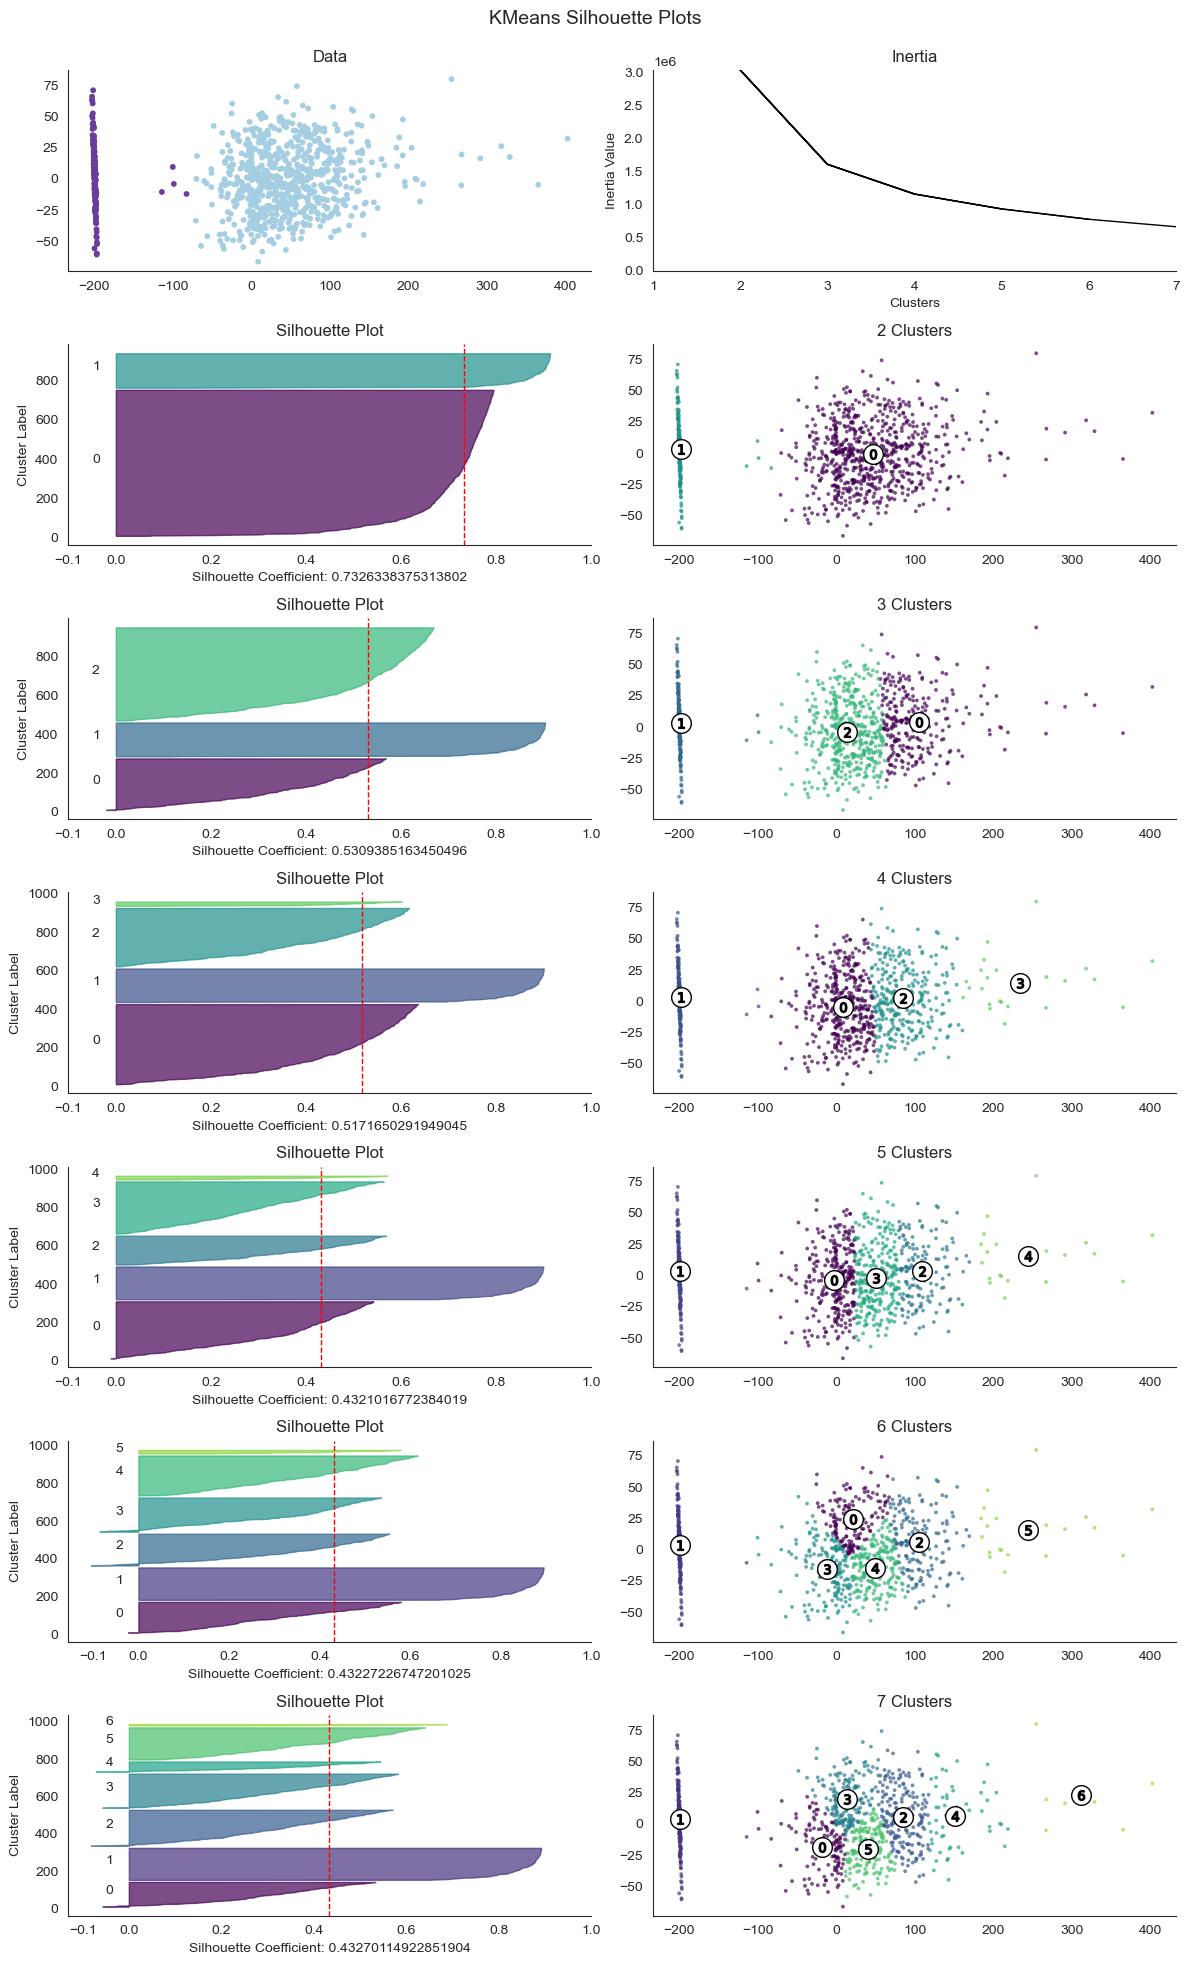

In [12]:
fig, axes = plt.subplots(ncols=2,
                         nrows=max_clusters,
                         figsize=(12, 20))

axes[0][0].scatter(pca_x, pca_y, c=kmeans.labels_, s=10, cmap=cmap)
axes[0][0].set_title('Data')

for i in range(max_clusters):
    for j in [0, 1]:
        axes[i][j].axes.get_xaxis().set_visible(True)
        axes[i][j].axes.get_yaxis().set_visible(True)
sns.despine()

for row, n_cluster in enumerate(range(2, max_clusters + 1), 1):
    kmeans = KMeans(n_clusters=n_cluster,
                    **kmeans_kwargs).fit(pca_data)

    centroids, assignments, inertia = (kmeans.cluster_centers_,
                                       kmeans.labels_,
                                       kmeans.inertia_)
    inertias[n_cluster] = inertia
    inertia_plot_update(inertias, axes[0][1])

    silhouette_avg = silhouette_score(pca_data, assignments)
    silhouette_values = silhouette_samples(pca_data, assignments)
    silhouette_plot, cluster_plot = axes[row]

    y_lower = 10
    for i in range(n_cluster):
        y_lower = plot_silhouette(np.sort(silhouette_values[assignments == i]),
                                  y_lower,
                                  i,
                                  n_cluster,
                                  silhouette_plot)
    format_silhouette_plot(silhouette_plot)
    plot_final_assignments(pca_x, pca_y, centroids, assignments,
                           n_cluster, cluster_plot)
    fig.tight_layout()


fig.suptitle(f'KMeans Silhouette Plots',
             fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.95)

# Resultat

Her er der fine plots som er med til at visualisere silhouette scoren, samt nogle plots til højre for at visualisere clusterne og inertia.

Silhouette evaluere mængden af clusters ved at måle, hvor godt hvert datapunkt passer til sit tildelte cluster sammenlignet med andre clusters.

2 clusters får klart den bedste score her, da 1 er den bedste score man kan få. Det er også visuelt tydeligt.